In [5]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest, chi2

# Data Processing In Main Notebook

In [6]:
df = pd.read_csv('secondary_data.csv',sep=';', on_bad_lines='skip')
df = df.rename(columns={"Cap-surface": "cap-surface"})

df = df.drop(columns=['spore-print-color',
                     'has-ring'])

#Binary Encoding
binary_mapping = {'[t]': 1, '[f]': 0}
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].map(binary_mapping)
binary_mapping = {'p': 1, 'e': 0}
df['class'] = df['class'].map(binary_mapping)

df = df.drop(columns=['stem-root', 'stem-surface', 'veil-type', 'veil-color'])

df['gill-attachment'].fillna('[?]', inplace=True)
df['ring-type'].fillna('[?]', inplace=True)
df['cap-surface'].fillna('[?]', inplace=True)
df['gill-spacing'].fillna('[?]', inplace=True)

columns_to_apply_multilabeling = ['cap-shape','cap-surface','cap-color','gill-attachment', 'gill-spacing', 'gill-color','stem-color','ring-type','season']

for col in columns_to_apply_multilabeling:
    mlb = MultiLabelBinarizer()
    column = df[col].apply(lambda x: x.strip('[]').split(', '))
    
    encoded_data = mlb.fit_transform(column)
    encoded_df = pd.DataFrame(encoded_data, columns=mlb.classes_+"_"+col)
    df = df.drop(col, axis=1)
    df = pd.concat([df, encoded_df], axis=1)

X = df.drop(columns = {'habitat','cap-diameter','stem-height','stem-width'})

##drop all columns with NAN
X = X.dropna(axis=1)

y = df['habitat']

selector = SelectKBest(score_func=chi2, k=10)  # Specify the desired number of features
X_selected = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices]
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)

#Encoding y
mlb = MultiLabelBinarizer()

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

C:\Users\Neil\AppData\Local\Temp\ipykernel_30656\3687707237.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gill-attachment'].fillna('[?]', inplace=True)
C:\Users\Neil\AppData\Local\Temp\ipykernel_30656\3687707237.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

# Random Forest

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]     
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score achieved: {grid_search.best_score_}")

# Use the best estimator to make predictions on the test set
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

from sklearn.metrics import accuracy_score
print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score achieved: 0.8340804421246546
Test set accuracy: 0.828393646635009


In [5]:
from joblib import dump, load

model_filename = 'random_forest_model.model'
dump(best_estimator, model_filename)

['random_forest_model.model']

In [1]:
from joblib import dump, load

model = load('random_forest_model.model')

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

y_pred = model.predict(X_test)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      8856
           1       0.72      0.72      0.72      1583
           2       0.44      0.45      0.45       409
           3       0.54      0.50      0.52       639
           4       0.54      0.53      0.53       566
           5       0.53      0.62      0.57        76
           6       0.35      0.29      0.32        24
           7       1.00      1.00      1.00        61

    accuracy                           0.83     12214
   macro avg       0.63      0.63      0.63     12214
weighted avg       0.83      0.83      0.83     12214

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     35353
           1       0.79      0.79      0.79      6360
           2       0.54      0.57      0.55      1592
           3       0.65      0.62      0.63      2529
           4       0.70      0.66      0.68      2354
           5       0.58 

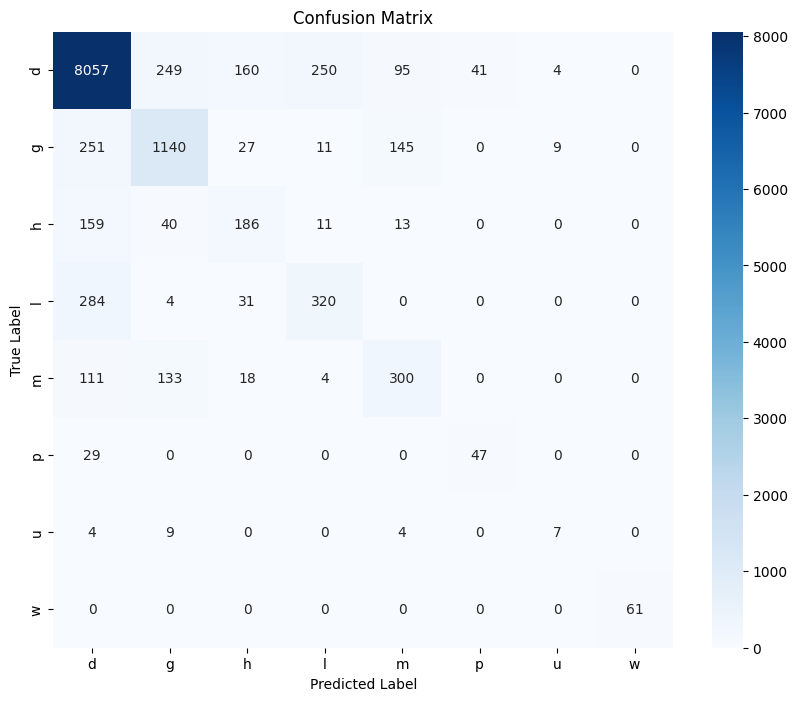

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
class_names = encoder.classes_  # Adjust based on your encoding

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

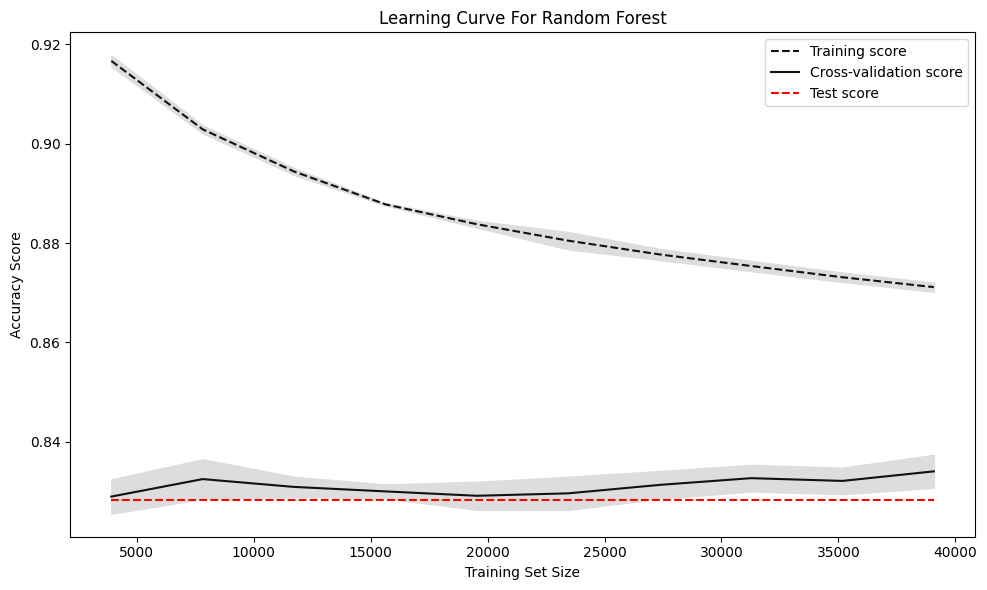

In [23]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
import numpy as np

# Generating learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model,
    X=X_train,  # Use the training part of data here
    y=y_train,  # Use the encoded target variable of the training part
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Using accuracy as the scoring parameter
    n_jobs=-1  # Use all available cores
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Calculate test score using the entire test set (for plotting)
# Note: This uses the final model trained on the full training set, not the subsets used in learning_curve
test_score = accuracy_score(y_test, y_pred)

# Plotting learning curve
plt.subplots(1, figsize=(10,6))
plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
plt.plot(train_sizes, validation_mean, color="#111111", label="Cross-validation score")

# Add test score to the plot
plt.hlines(test_score, train_sizes[0], train_sizes[-1], colors='red', label='Test score', linestyles='dashed')

# Drawing bands for the standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="#DDDDDD")

# Creating the plot
plt.title("Learning Curve For Random Forest")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()
